Created on Thu Oct 26 10:28:08 2023

@author: Santiago D'hers

Use:

- This script will help us visualize the results of labeled videos

Requirements:

- The position.csv files processed by 1-Manage_H5.py

- Geolabels, autolabels or manual labels

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np

from itertools import chain

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import plotly.graph_objs as go
from plotly.subplots import make_subplots

import csv

In [2]:
# State your path:
path = r'C:\Users\dhers\OneDrive - UBA\workshop'
experiment = r'FC'

folder = os.path.join(path, experiment)
trials = ['TR', 'TS']
objects = []

t_lim = None # seconds
video_fps = 12.5

In [3]:
def create_reference(folder, trials, objects):
    
    reference_path = os.path.join(folder, 'reference.csv')
    
    # Check if Reference.csv already exists
    if os.path.exists(reference_path):
        print("Reference file already exists")
        return reference_path
    
    all_labels_files=[]

    # Get a list of all CSV files in the labels folder
    for trial in trials:
        labels_files = glob(os.path.join(folder,f"{trial}/position/*position.csv"))
        labels_files = sorted(labels_files)
        all_labels_files += labels_files

    # Create a new CSV file with a header 'Videos'
    with open(reference_path, 'w', newline='') as output_file:
        csv_writer = csv.writer(output_file)
        col_list = ['Video', 'Group'] + objects
        csv_writer.writerow(col_list)

        # Write each position file name in the 'Videos' column
        for file in all_labels_files:
            # Remove "_position.csv" from the file name
            clean_name = os.path.basename(file).replace(f'_position.csv', '')
            csv_writer.writerow([clean_name])

    print(f"CSV file '{reference_path}' created successfully with the list of video files.")
    
    return reference_path

In [4]:
# Lets create the reference.csv file
reference_path = create_reference(folder, trials, objects)

Reference file already exists


STOP! Go to the Reference file and complete the 'Group','Left' and 'Right' columns

In [5]:
def create_summary_folder(reference_path, trials):
    
    parent_dir = os.path.dirname(reference_path)
    reference = pd.read_csv(reference_path)
    
    # Create a subfolder named "final_{label_type}"
    summary_path = os.path.join(parent_dir, f'summary')

    # Check if it exists
    if os.path.exists(summary_path):
        print(f'summary folder already exists')
    else:
        os.makedirs(summary_path, exist_ok = True)
    
    group_list = []
    
    # Iterate through each row in the table
    for index, row in reference.iterrows():
        
        video_name = row['Video']
        group = row['Group']

        group_path = os.path.join(summary_path, group)
        os.makedirs(group_path, exist_ok = True)

        for trial in trials:
            if trial in video_name:

                trial_path = os.path.join(group_path, trial)
                os.makedirs(trial_path, exist_ok = True)

                # Find the old file path
                old_path = os.path.join(parent_dir, trial, 'movement', f'{video_name}_movement.csv')
                    
                # Read the CSV file into a DataFrame
                df = pd.read_csv(old_path)

                # Create the new file path
                new_name = f'{video_name}_summary.csv'
                new_path = os.path.join(trial_path, new_name)
        
                # Save the modified DataFrame to a new CSV file
                df.to_csv(new_path, index=False)
        
        group_list.append(group)
    
        print(f'Renamed and saved: {new_path}')
    
    group_list = sorted(list(set(group_list)))
        
    return summary_path, group_list

In [6]:
# Lets rename the labels
summary_path, groups = create_summary_folder(reference_path, trials)

summary folder already exists
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\FC\summary\W_VEH\TR\TR_C1_M0_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\FC\summary\W_RG\TR\TR_C1_M1_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\FC\summary\S_VEH\TR\TR_C1_M2_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\FC\summary\W_VEH\TR\TR_C1_M3_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\FC\summary\S_VEH\TR\TR_C1_M4_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\FC\summary\S_VEH\TR\TR_C2_M0_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\FC\summary\W_RG\TR\TR_C2_M1_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\FC\summary\W_VEH\TR\TR_C2_M2_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\FC\summary\S_VEH\TR\TR_C2_M3_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\FC\summary\W_RG\TR\TR_C

In [7]:
def calculate_durations(series, fps=30):
    durations = []
    count = 0
    for value in series:
        if value > 0.5:
            count += 1
        else:
            if count >= fps//2:
                durations.append(count/fps)
                count = 0
    if count >= fps//2:
        durations.append(count/fps)
    return durations

In [8]:
def plot_group(path, group, trials, fps=30):

    # Create a single figure
    fig, axes = plt.subplots(len(trials), 4, figsize=(16, 4*len(trials)))

    for i, trial in enumerate(trials):
        # Initialize an empty list to store DataFrames
        dfs = []

        for filename in os.listdir(os.path.join(path, group, trial)):
            file_path = os.path.join(path, group, trial, filename)
            df = pd.read_csv(file_path)
            
            df["nose_dist_cumsum"] = df["nose_dist"].cumsum()
            df["body_dist_cumsum"] = df["body_dist"].cumsum()
            df["freezing_cumsum"] = df["freezing"].cumsum()/fps
            df["darting_cumsum"] = df["darting"].cumsum()/fps
            
            dfs.append(df)
    
        n = len(dfs)  # We find the number of mice to calculate the standard error as std/sqrt(n)
        se = np.sqrt(n)
        
        # Find the minimum length of all files
        min_length = min([len(df) for df in dfs])
        trunc_dfs = [df.iloc[:min_length] for df in dfs]
        
        # Concatenate the list of DataFrames into one DataFrame
        all_dfs = pd.concat(trunc_dfs, ignore_index=True)
        
        # Calculate the mean and standard deviation of cumulative sums for each frame
        df = all_dfs.groupby('Frame').agg(['mean', 'std']).reset_index()
        
        df['time_seconds'] = df['Frame']/fps
        
        # Distance covered
        axes[i, 0].plot(df['time_seconds'], df[("nose_dist_cumsum", 'mean')], label="Nose distance")
        axes[i, 0].fill_between(df['time_seconds'], df[("nose_dist_cumsum", 'mean')] - df[("nose_dist_cumsum", 'std')]/se, df[("nose_dist_cumsum", 'mean')] + df[("nose_dist_cumsum", 'std')]/se, alpha=0.2)
        axes[i, 0].plot(df['time_seconds'], df[("body_dist_cumsum", 'mean')], label="Body distance")
        axes[i, 0].fill_between(df['time_seconds'], df[("body_dist_cumsum", 'mean')] - df[("body_dist_cumsum", 'std')]/se, df[("body_dist_cumsum", 'mean')] + df[("body_dist_cumsum", 'std')]/se, alpha=0.2)
        axes[i, 0].set_xlabel('Time (s)')
        axes[i, 0].set_xticks([0, 60, 120, 180, 240, 300])
        axes[i, 0].set_ylabel('Distance (m)')
        axes[i, 0].set_title('Distance Traveled')
        axes[i, 0].legend(loc='upper left', fancybox=True, shadow=True)
        axes[i, 0].grid(True)
        
        # Freezing
        axes[i, 1].plot(df['time_seconds'], df[("freezing_cumsum", 'mean')], label="Freezing")
        axes[i, 1].fill_between(df['time_seconds'], df[("freezing_cumsum", 'mean')] - df[("freezing_cumsum", 'std')]/se, df[("freezing_cumsum", 'mean')] + df[("freezing_cumsum", 'std')]/se, alpha=0.2)
        axes[i, 1].set_xlabel('Time (s)')
        axes[i, 1].set_xticks([0, 60, 120, 180, 240, 300])
        axes[i, 1].set_ylabel('Time (s)')
        axes[i, 1].set_title('Freezing')
        axes[i, 1].legend(loc='upper left', fancybox=True, shadow=True)
        axes[i, 1].grid(True)
        
        # Histogram of freezing event durations
        all_freezing_durations = []
        for h in trunc_dfs:
            all_freezing_durations.extend(calculate_durations(h["freezing"], fps=fps))
        n_bins = int(np.sqrt(len(all_freezing_durations)))

        axes[i, 2].hist(all_freezing_durations, bins=n_bins, alpha=0.75)
        axes[i, 2].set_xlabel('Duration (s)')
        axes[i, 2].set_ylabel('Events')
        axes[i, 2].set_title('Histogram of Freezing Durations')
        axes[i, 2].set_xlim([0, None])

        # Darting
        axes[i, 3].plot(df['time_seconds'], df[("darting_cumsum", 'mean')], label="Darting")
        axes[i, 3].fill_between(df['time_seconds'], df[("darting_cumsum", 'mean')] - df[("darting_cumsum", 'std')]/se, df[("darting_cumsum", 'mean')] + df[("darting_cumsum", 'std')]/se, alpha=0.2)
        axes[i, 3].set_xlabel('Time (s)')
        axes[i, 3].set_xticks([0, 60, 120, 180, 240, 300])
        axes[i, 3].set_ylabel('Time (s)')
        axes[i, 3].set_title('Darting')
        axes[i, 3].legend(loc='upper left', fancybox=True, shadow=True)
        axes[i, 3].grid(True)
        
    plt.suptitle(f"Analysis of {group}", y=0.98)  # Add DataFrame name as the overall title
    plt.tight_layout()
    plt.savefig(os.path.join(path, f"{group}.png"))
    plt.show()

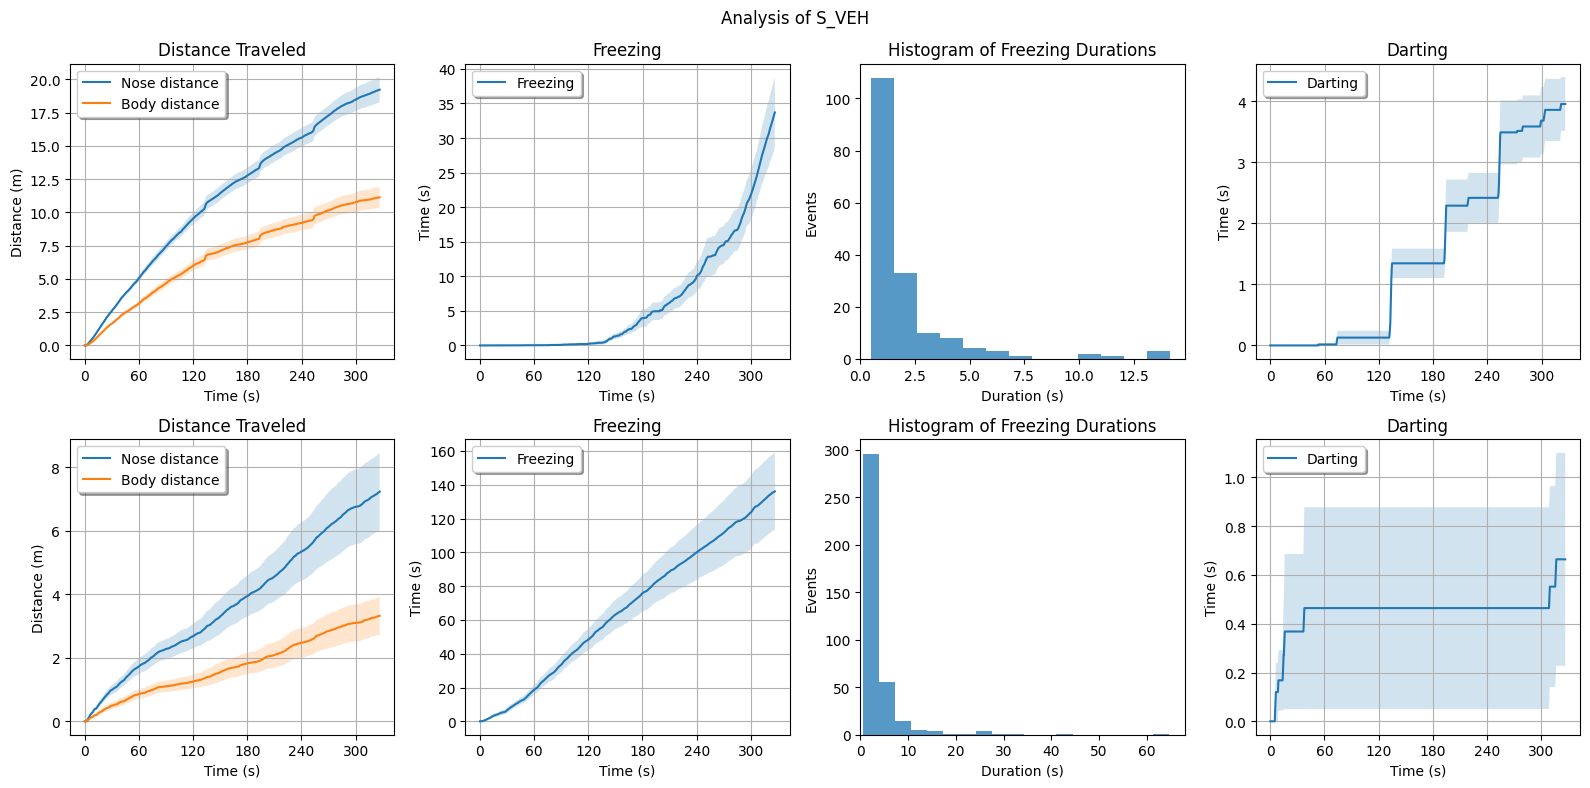

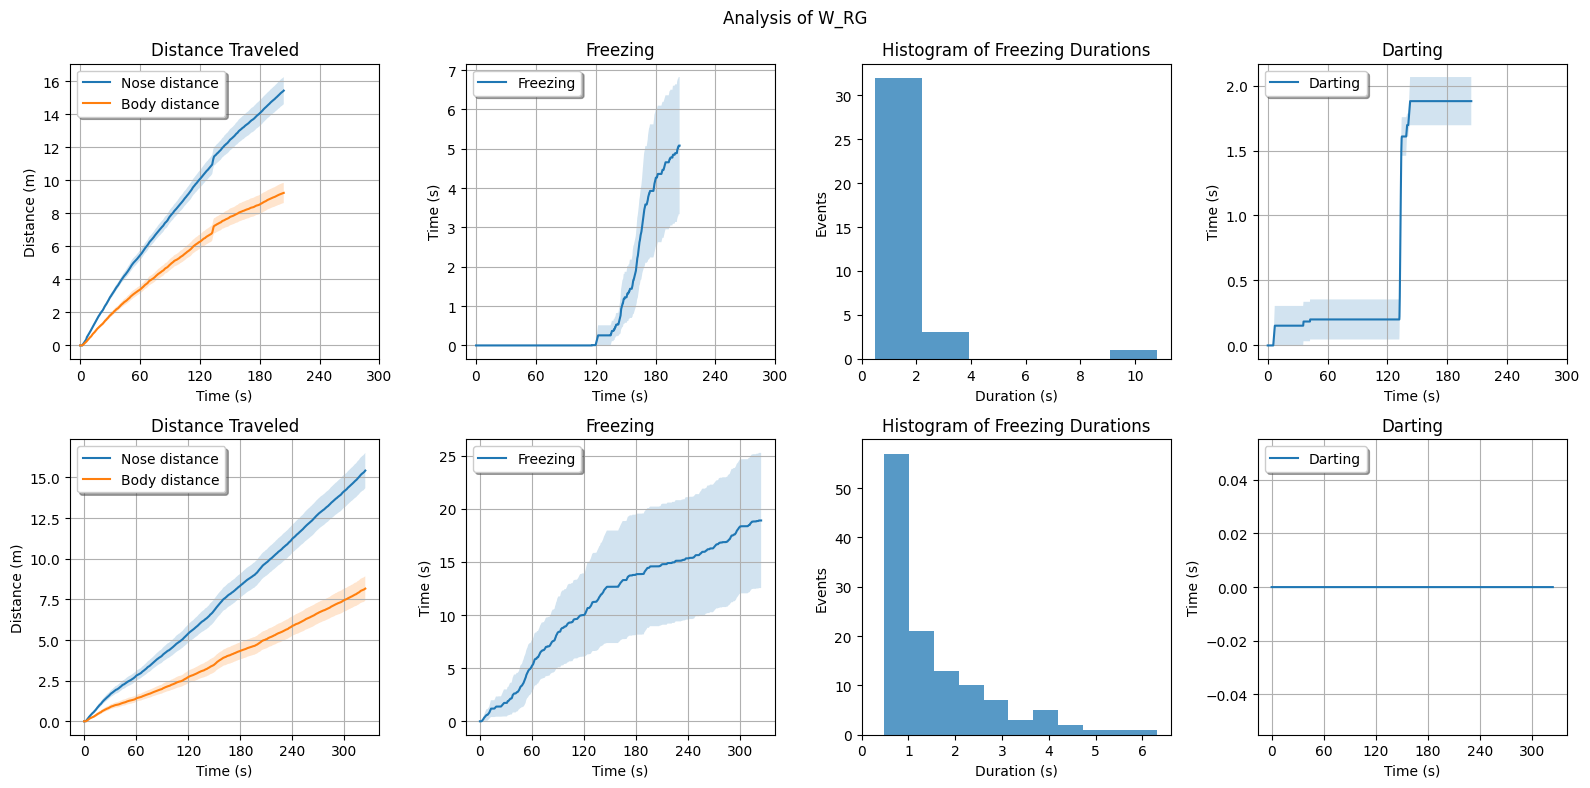

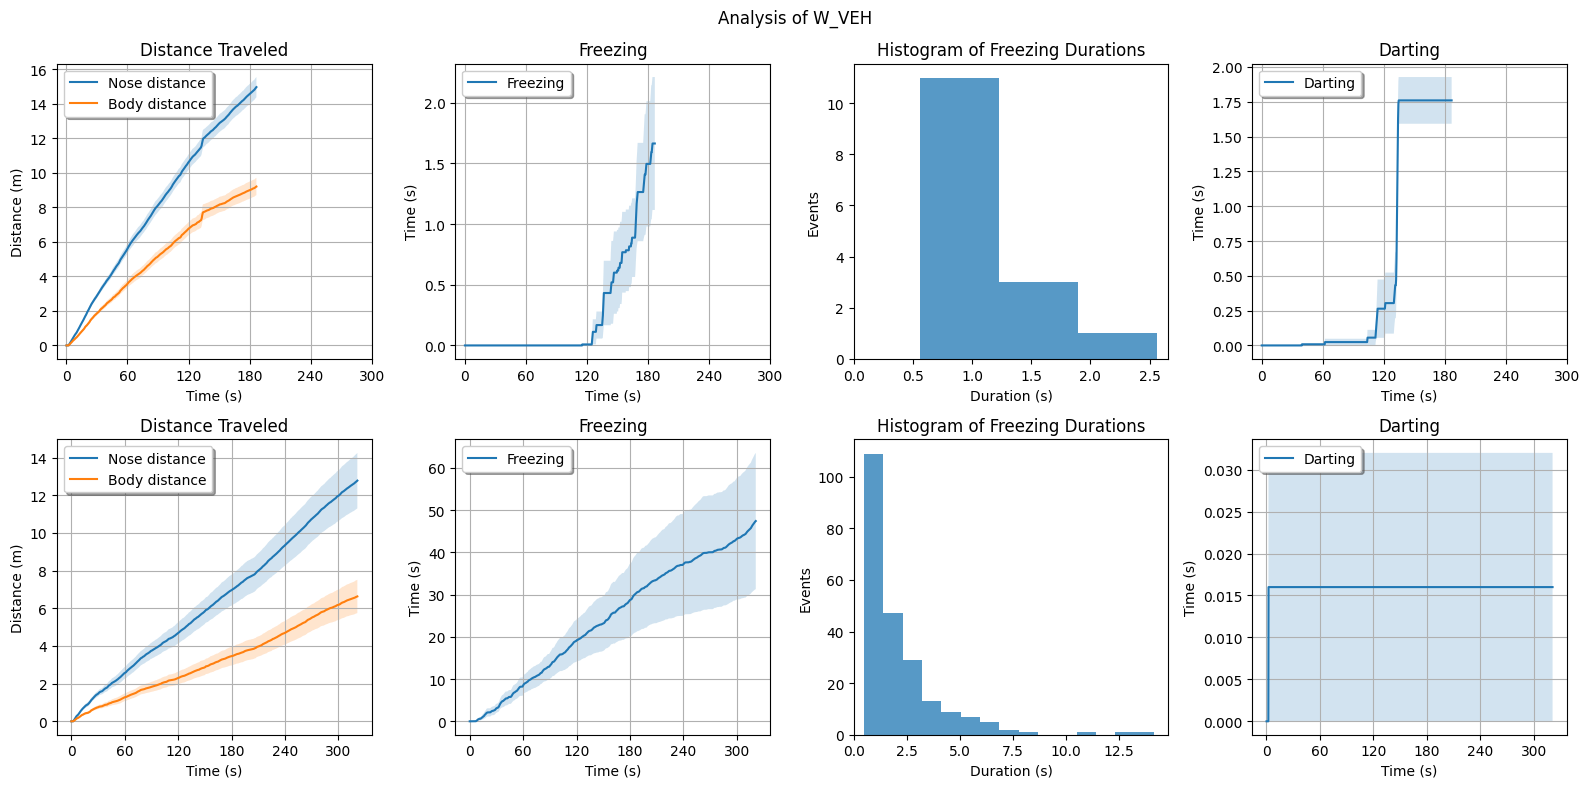

In [9]:
for group in groups:
    plot_group(summary_path, group, trials, fps = video_fps)

In [10]:
def prepare_group(path, group, trial, fps=30):
    
    dfs = []
    
    for filename in os.listdir(os.path.join(path, group, trial)):
        file_path = os.path.join(path, group, trial,filename)
        df = pd.read_csv(file_path)
        
        df["nose_dist_cumsum"] = df["nose_dist"].cumsum()
        df["body_dist_cumsum"] = df["body_dist"].cumsum()
        df["freezing_cumsum"] = df["freezing"].cumsum() / fps
        
        dfs.append(df)
    
    n = len(dfs)
    se = np.sqrt(n)
    
    min_length = min(len(df) for df in dfs)
    trunc_dfs = [df.iloc[:min_length] for df in dfs]
    all_dfs = pd.concat(trunc_dfs, ignore_index=True)
    
    aggregated_df = all_dfs.groupby('Frame').agg(['mean', 'std']).reset_index()
    aggregated_df['time_seconds'] = aggregated_df['Frame'] / fps
    
    return aggregated_df, trunc_dfs, se  # Return both aggregated and individual truncated DataFrames

def plot_experiment(path, groups, trials, fps=30):

    fig, axes = plt.subplots(len(trials), 4, figsize=(16, 4*len(trials)))

    for i, trial in enumerate(trials):

        bxplt_positions = list(range(1, len(groups) + 1))
        
        for j, group in enumerate(groups):
            aggregated_df, trunc_dfs, se = prepare_group(path, group, trial, fps)
            
            # Plot distance
            axes[i, 0].plot(aggregated_df['time_seconds'], aggregated_df[("nose_dist_cumsum", 'mean')], label=f"{group} nose")
            axes[i, 0].fill_between(aggregated_df['time_seconds'], aggregated_df[("nose_dist_cumsum", 'mean')] - aggregated_df[("nose_dist_cumsum", 'std')]/se, 
                                aggregated_df[("nose_dist_cumsum", 'mean')] + aggregated_df[("nose_dist_cumsum", 'std')]/se, alpha=0.2)
            
            """axes[i, 0].plot(aggregated_df['time_seconds'], aggregated_df[("body_dist_cumsum", 'mean')], label=f"{group} body", linestyle='--')
            axes[i, 0].fill_between(aggregated_df['time_seconds'], aggregated_df[("body_dist_cumsum", 'mean')] - aggregated_df[("body_dist_cumsum", 'std')]/se, 
                                aggregated_df[("body_dist_cumsum", 'mean')] + aggregated_df[("body_dist_cumsum", 'std')]/se, alpha=0.1)"""
            
            # Plot freezing
            axes[i, 1].plot(aggregated_df['time_seconds'], aggregated_df[("freezing_cumsum", 'mean')], label=f"{group}")
            axes[i, 1].fill_between(aggregated_df['time_seconds'], aggregated_df[("freezing_cumsum", 'mean')] - aggregated_df[("freezing_cumsum", 'std')]/se, 
                                aggregated_df[("freezing_cumsum", 'mean')] + aggregated_df[("freezing_cumsum", 'std')]/se, alpha=0.2)

            # Histogram of freezing event durations
            all_freezing_durations = []
            bxplt = []
            for df in trunc_dfs:
                all_freezing_durations.extend(calculate_durations(df["freezing"], fps=fps))
                bxplt.append((df.loc[df.index[-1], "freezing_cumsum"])*100*fps/len(df))
            
            log_durations = np.log([duration for duration in all_freezing_durations])
            n_bins = int(np.sqrt(len(log_durations)))
            axes[i, 2].hist(log_durations, bins=n_bins, alpha=0.5, label=f"{group}")

            # Boxplot
            bxplt = pd.DataFrame(bxplt)
            axes[i, 3].boxplot(bxplt[0], positions=[bxplt_positions[j]], tick_labels = [f'{group}'], widths=0.25)
            jitter_amount = 0.1  # Adjust the jitter amount as needed
            axes[i, 3].scatter([j + 1 + np.random.uniform(-jitter_amount, jitter_amount) for _ in range(len(bxplt[0]))], bxplt[0], alpha=0.5, label=f'{group}')
        
        # Customize distance plot
        axes[i, 0].set_xlabel('Time (s)')
        axes[i, 0].set_ylabel('Distance (m)')
        axes[i, 0].set_title(f'Distance Traveled in {trial}')
        axes[i, 0].legend(loc='upper left')
        axes[i, 0].grid(True)

        # Customize freezing plot
        axes[i, 1].set_xlabel('Time (s)')
        axes[i, 1].set_ylabel('Time Freezing (s)')
        axes[i, 1].set_title(f'Freezing in {trial}')
        axes[i, 1].legend(loc='upper left')
        axes[i, 1].grid(True)

        # Plot histogram
        # axes[i, 2].set_xscale('log')
        # axes[i, 2].set_xlim([0, 30])
        axes[i, 2].set_xlabel('Log(Duration) (s)')
        axes[i, 2].set_ylabel('Events')
        axes[i, 2].set_title(f'Freezing Events in {trial}')
        axes[i, 2].legend(loc='upper right')

        # Boxplot
        # axes[i, 3].axhline(y=0, color='black', linestyle='--', linewidth = 2)
        axes[i, 3].set_ylabel('Total Freezing (%)')
        axes[i, 3].set_title(f'Freezing in {trial} - Boxplot')
        axes[i, 3].grid(True)
        axes[i, 3].set_ylim([-1, None])
    
    plt.suptitle("Combined Group Analysis")
    plt.tight_layout()
    plt.show()

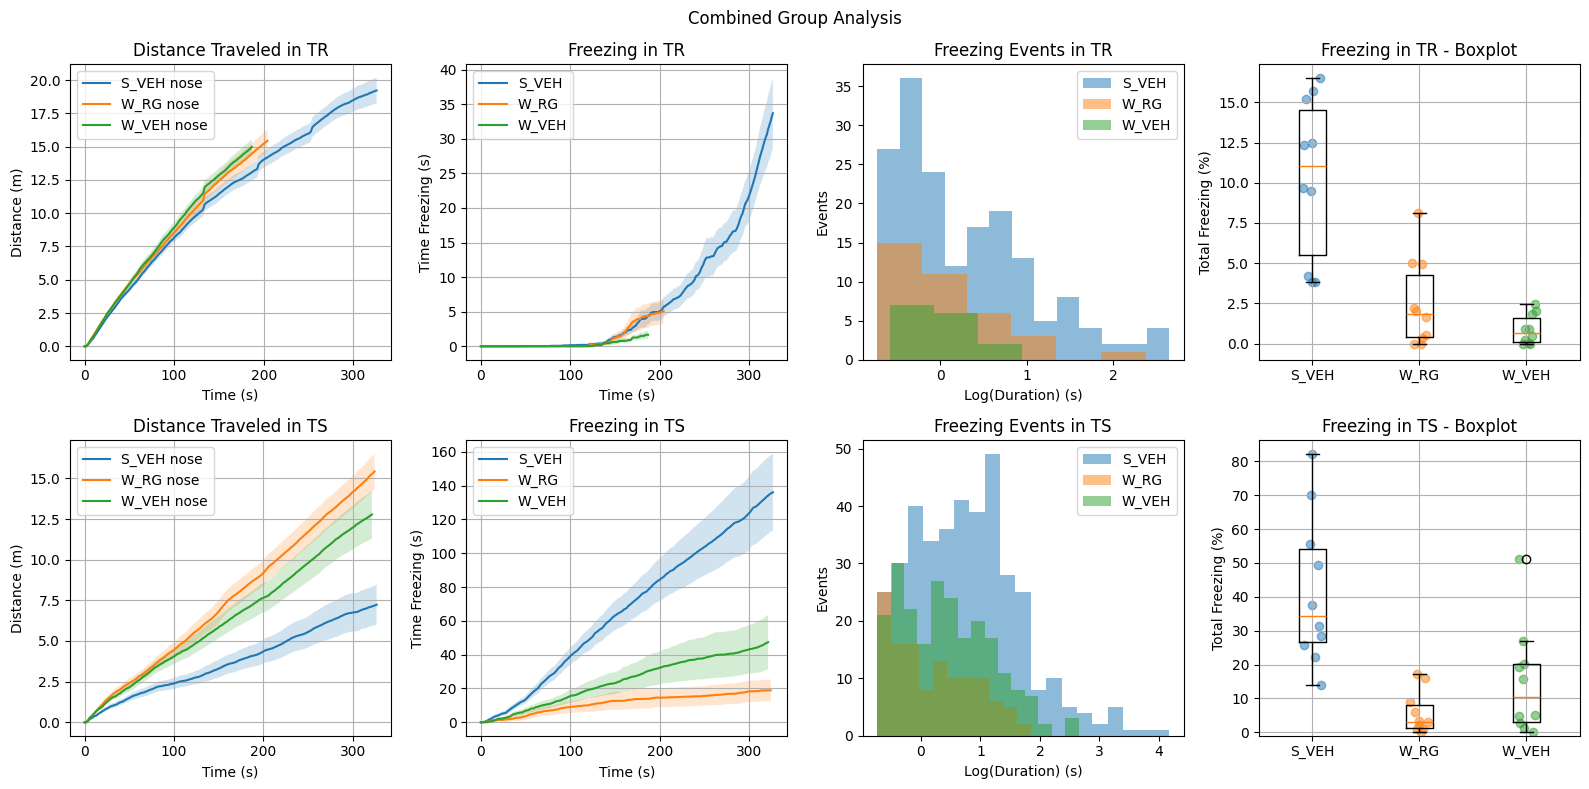

In [11]:
plot_experiment(summary_path, groups, trials, fps=video_fps)

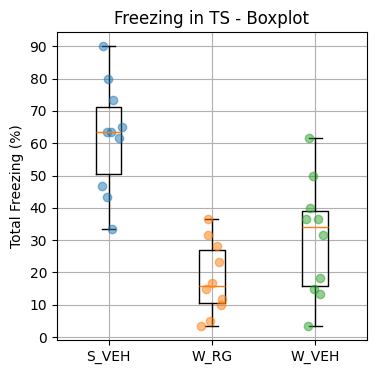

In [ ]:
df = pd.read_excel(r'c:\Users\dhers\OneDrive - UBA\DLC\FC\Results.xlsx', sheet_name='Resumen')

from matplotlib.ticker import MultipleLocator

# Define the desired order of the groups
group_order = ["S_VEH", "W_RG", "W_VEH"]

# Create a figure and axis
plt.figure(figsize=(4, 4))

# Create a box plot with a specific width
plt.boxplot([df[df['Group'] == group]['total freezing'] for group in group_order], 
            tick_labels=group_order, 
            widths=0.25)  # Adjust the width here

# Overlay individual data points with jitter
for i, group in enumerate(group_order):
    # Adding jitter
    jittered_x = np.random.normal(i + 1, 0.05, size=len(df[df['Group'] == group]))  # Adjust the scale of jitter here
    plt.plot(jittered_x, 
             df[df['Group'] == group]['total freezing'], 
             'o', alpha=0.5)

# Set y-axis ticks to increments of 10
plt.gca().yaxis.set_major_locator(MultipleLocator(10))

plt.xlabel("")
plt.ylabel("Total Freezing (%)")
plt.title("Freezing in TS - Boxplot")
plt.grid(True)
plt.ylim([-1, None])
plt.show()
